<a href="https://www.kaggle.com/code/def0017/style-transfer-using-cyclegan?scriptVersionId=200551333" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import tqdm
from torchvision.utils import save_image

## Discriminator Model

In [21]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride, initial=False):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=stride, padding=1, bias=True, padding_mode="reflect")
    self.instanceNorm = nn.InstanceNorm2d(out_channels)
    self.lrelu = nn.LeakyReLU(0.2)
    self.initial = initial

  def forward(self, x):
    x = self.conv(x)
    x = self.instanceNorm(x) if self.initial==False else x
    x = self.lrelu(x)
    return x

class Discriminator(nn.Module):
  def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
    super().__init__()
    layers=[]
    layers.append(CNNBlock(in_channels, features[0], 2, initial=True))
    in_channels = features[0]
    for feature in features[1:]:
      layers.append(CNNBlock(in_channels, feature, stride=1 if feature==features[-1] else 2))
      in_channels = feature
    layers.append(nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return torch.sigmoid(self.model(x))

## Generator Model

In [22]:
class cnnBlock(nn.Module):
  def __init__(self, in_channels, out_channels, up_sample=False, use_act=True, **kwargs):
    super().__init__()
    self.cnn_block = nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, **kwargs)
        if up_sample else
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, padding_mode="reflect", **kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(inplace=True) if use_act else nn.Identity()
    )

  def forward(self, x):
    return self.cnn_block(x)

class residualBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.resBlock = nn.Sequential(
        cnnBlock(channels, channels, kernel_size=3, padding=1),
        cnnBlock(channels, channels, use_act=False, kernel_size=3, padding=1)
    )

  def forward(self, x):
    return x + self.resBlock(x)

class Generator(nn.Module):
  def __init__(self, img_channels=3, features=64, num_residual=9):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(img_channels, 64, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
        nn.ReLU()
    )
    self.downBlock = nn.ModuleList([
        cnnBlock(features, features*2, kernel_size=3, stride=2, padding=1),
        cnnBlock(features*2, features*4, kernel_size=3, stride=2, padding=1)
    ])
    self.resBlock = nn.Sequential(*[residualBlock(features*4) for _ in range(num_residual)])
    self.upBlock = nn.ModuleList([
        cnnBlock(features*4, features*2, up_sample=True, kernel_size=3, stride=2, padding=1, output_padding=1),
        cnnBlock(features*2, features, up_sample=True, kernel_size=3, stride=2, padding=1, output_padding=1),
    ])
    self.final = nn.Conv2d(features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

  def forward(self, x):
    x = self.initial(x)
    for layer in self.downBlock:
      x = layer(x)
    x = self.resBlock(x)
    for layer in self.upBlock:
      x = layer(x)
    x = self.final(x)
    return torch.tanh(x)

In [23]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/kaggle/input/vangogh2photo/vangogh2photo/train"
VAL_DIR = "/kaggle/input/vangogh2photo/vangogh2photo/val"
BATCH_SIZE = 1
LEARNING_RATE = 2e-4
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 1
LOAD_MODEL = True
SAVE_MODEL = False
CHECKPOINT_GEN_B = "/kaggle/input/checkpoints/genB.pth.tar"
CHECKPOINT_GEN_A = "/kaggle/input/checkpoints/genA.pth.tar"
CHECKPOINT_DISC_A = "/kaggle/input/checkpoints/discA.pth.tar"
CHECKPOINT_DISC_B = "/kaggle/input/checkpoints/discB.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
    is_check_shapes=False
)

In [24]:
class ABDataset(Dataset):
  def __init__(self, root_A, root_B, transform=None):
    self.root_A = root_A
    self.root_B = root_B
    self.transform = transform
    self.A_images = os.listdir(root_A)
    self.B_images = os.listdir(root_B)
    self.A_len = len(self.A_images)
    self.B_len = len(self.B_images)
    self.length_dataset = max(self.A_len, self.B_len) # 1000, 1500

  def __len__(self):
    return self.length_dataset

  def __getitem__(self, index):
    A_img = self.A_images[index % self.A_len]
    B_img = self.B_images[index % self.B_len]

    A_path = os.path.join(self.root_A, A_img)
    B_path = os.path.join(self.root_B, B_img)

    A_img = np.array(Image.open(A_path).convert("RGB"))
    B_img = np.array(Image.open(B_path).convert("RGB"))

    if self.transform:
      augmentations = self.transform(image=A_img, image0=B_img)
      A_img = augmentations["image"]
      B_img = augmentations["image0"]

    return A_img, B_img

In [25]:
def train_fn(discA, discB, genB, genA, loader, optim_disc, optim_gen, l1, mse, d_scaler, g_scaler):
  H_reals = 0
  H_fakes = 0
  loop = tqdm(loader, leave=True)

  for idx, (imgA, imgB) in enumerate(loop):
    imgA = imgA.to(DEVICE)
    imgB = imgB.to(DEVICE)

    # Train Discriminator
    with torch.cuda.amp.autocast():
      fake_imgA = genA(imgB)
      dA_real = discA(imgA)
      dA_fake = discA(fake_imgA.detach())

      lossA_real = mse(dA_real, torch.ones_like(dA_real))
      lossA_fake = mse(dA_fake, torch.zeros_like(dA_fake))
      lossA = lossA_real + lossA_fake

      fake_imgB = genB(imgA)
      dB_real = discB(imgB)
      dB_fake = discB(fake_imgB.detach())

      lossB_real = mse(dB_real, torch.ones_like(dB_real))
      lossB_fake = mse(dB_fake, torch.zeros_like(dB_fake))
      lossB = lossB_real + lossB_fake

      D_loss = (lossA+lossB)/2

    optim_disc.zero_grad()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(optim_disc)
    d_scaler.update()

    # Train Generator
    with torch.cuda.amp.autocast():
      # Adversarial Loss
      dA_fake = discA(fake_imgA)
      dB_fake = discB(fake_imgB)
      lossA_fake = mse(dA_fake, torch.ones_like(dA_fake))
      lossB_fake = mse(dB_fake, torch.ones_like(dB_fake))

      # Cycle Loss
      cycleB = genB(fake_imgA)
      cycleA = genA(fake_imgB)
      cycleA_loss = l1(imgA, cycleA)
      cycleB_loss = l1(imgB, cycleB)

      # Identity Loss
      identityA = genA(imgA)
      identityB = genB(imgB)
      identityA_loss = l1(imgA, identityA)
      identityB_loss = l1(imgB, identityB)

      # total loss
      G_loss = lossA_fake + lossB_fake + LAMBDA_CYCLE*(cycleA_loss + cycleB_loss) + LAMBDA_IDENTITY*(identityA_loss + identityB_loss)

    optim_gen.zero_grad()
    g_scaler.scale(G_loss).backward()
    g_scaler.step(optim_gen)
    g_scaler.update()

    if idx % 200 == 0:
      save_image(fake_imgA * 0.5 + 0.5, f"/kaggle/working/A_{idx}.png")
      save_image(fake_imgB * 0.5 + 0.5, f"/kaggle/working/B_{idx}.png")

    loop.set_postfix(H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))

In [26]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [27]:
discA = Discriminator().to(DEVICE)
discB = Discriminator().to(DEVICE)
genB = Generator().to(DEVICE)
genA = Generator().to(DEVICE)
def main():
  optim_disc = optim.Adam(list(discA.parameters()) + list(discB.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999))
  optim_gen = optim.Adam(list(genB.parameters()) + list(genA.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999))
  l1 = nn.L1Loss()
  mse = nn.MSELoss()

  if LOAD_MODEL:
    load_checkpoint(CHECKPOINT_GEN_A, genA, optim_gen, LEARNING_RATE)
    load_checkpoint(CHECKPOINT_GEN_B, genB, optim_gen, LEARNING_RATE)
    load_checkpoint(CHECKPOINT_DISC_A, discA, optim_disc, LEARNING_RATE)
    load_checkpoint(CHECKPOINT_DISC_B, discB, optim_disc, LEARNING_RATE)

  dataset = ABDataset(root_A=TRAIN_DIR + "/trainA", root_B=TRAIN_DIR + "/trainB", transform=transforms)
  val_dataset = ABDataset(root_A=VAL_DIR + "/testA", root_B=VAL_DIR + "/testB", transform=transforms)
  val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True)
  loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
  g_scaler = torch.cuda.amp.GradScaler()
  d_scaler = torch.cuda.amp.GradScaler()

  for epoch in range(NUM_EPOCHS):
    print("Epoch: ", epoch)
    train_fn(discA, discB, genB, genA, loader, optim_disc, optim_gen, l1, mse, d_scaler, g_scaler)

    if SAVE_MODEL:
      save_checkpoint(genA, optim_gen, filename="genA.pth.tar")
      save_checkpoint(genB, optim_gen, filename="genB.pth.tar")
      save_checkpoint(discA, optim_disc, filename="discA.pth.tar")
      save_checkpoint(discB, optim_disc, filename="discA.pth.tar")

if __name__ == "__main__":
    main()

=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
Epoch:  0


100%|██████████| 1500/1500 [05:35<00:00,  4.47it/s, H_fake=0, H_real=0]


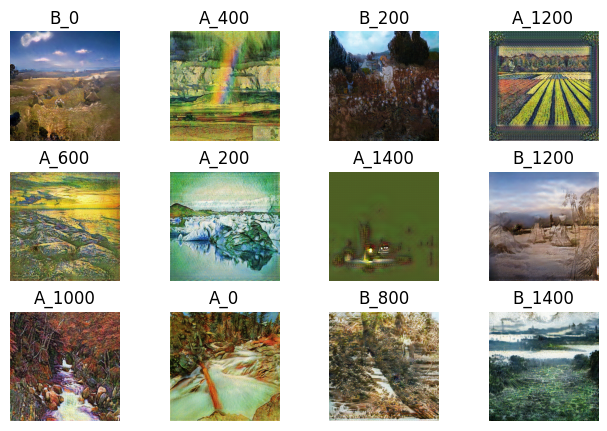

In [28]:
import matplotlib.pyplot as plt
import cv2

dir = []
figure, axis = plt.subplots(3, 4)
figure.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91])
for x in os.listdir("/kaggle/working/"):
    split_x = os.path.splitext(x)
    if split_x[-1] == ".png":
        dir.append(x)

for ax, x in zip(axis.flat, dir):
    split_x = os.path.splitext(x)
    img = cv2.imread("/kaggle/working/" + x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(split_x[0])
    ax.set_axis_off()
plt.show()

In [29]:
transforms2 = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    is_check_shapes=False
)
def style_transfer(img_file):
    img = np.array(Image.open(img_file))
    transform_img = transforms2(image=img)
    input_img = transform_img["image"]
    input_img = input_img.to(DEVICE)
    output_img = genA(input_img)
    save_image(output_img*0.5 + 0.5, f"/kaggle/working/output.png")

In [30]:
img_file = "/kaggle/input/vangogh2photo/vangogh2photo/val/testB/739.jpg"
style_transfer(img_file)

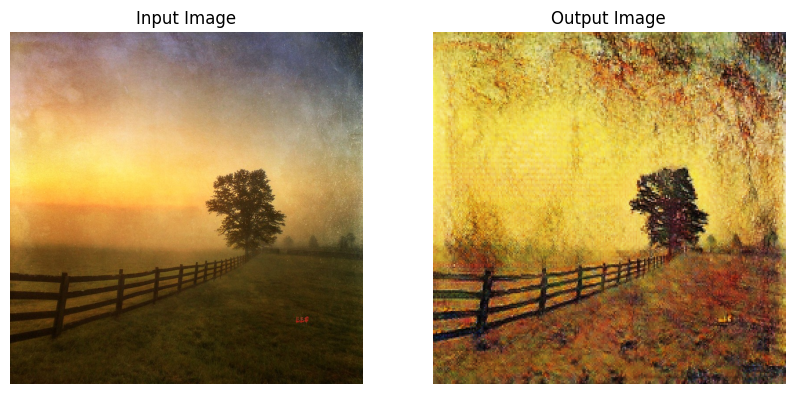

In [31]:
output_img = cv2.imread('/kaggle/working/output.png')
input_img = cv2.imread('/kaggle/input/vangogh2photo/vangogh2photo/val/testB/739.jpg')
output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image in the first subplot
axes[0].imshow(input_img)
axes[0].set_title('Input Image')
axes[0].axis('off')  # Hide axes

# Display the second image in the second subplot
axes[1].imshow(output_img)
axes[1].set_title('Output Image')
axes[1].axis('off')  # Hide axes

# Show the plot
plt.show()